In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
#import MTS operator #our custom class
from MTSNet_arch import *
from torchvision import datasets, transforms
print(torch.__version__)

2.5.1


## Linear Operators in machine learning
Any linear system can be represented in matrix vector form given by:
$$
\mathbf{y} = \mathbf{Ds},
$$
where:
- $\mathbf{y} \in \mathbb{R}^m$ is the measurement vector or feature map (output of the layer in machine learning literature),
- $\mathbf{D}$ is an $m \times n$ transformation matrix, i.e., in machine learning it is learned via training
- $\mathbf{s}  \in \mathbb{R}^n $ is the input vector (input of this layer in deep neural networks).


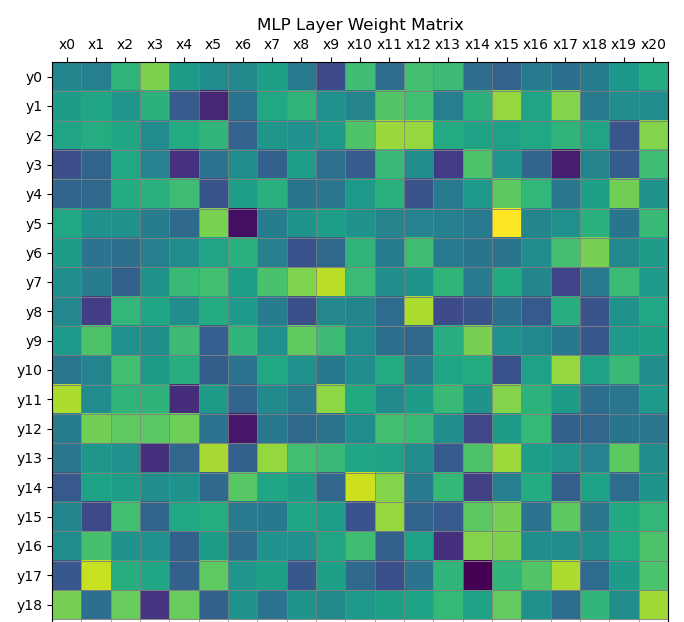

In [3]:

from IPython.display import Image, display
display(Image(filename="MLP_layer.png", width=400, height=400)) 


## Dense Layer is not feasible for large scale signals
Different factorization techniques had been proposed, e.g., convolution operator

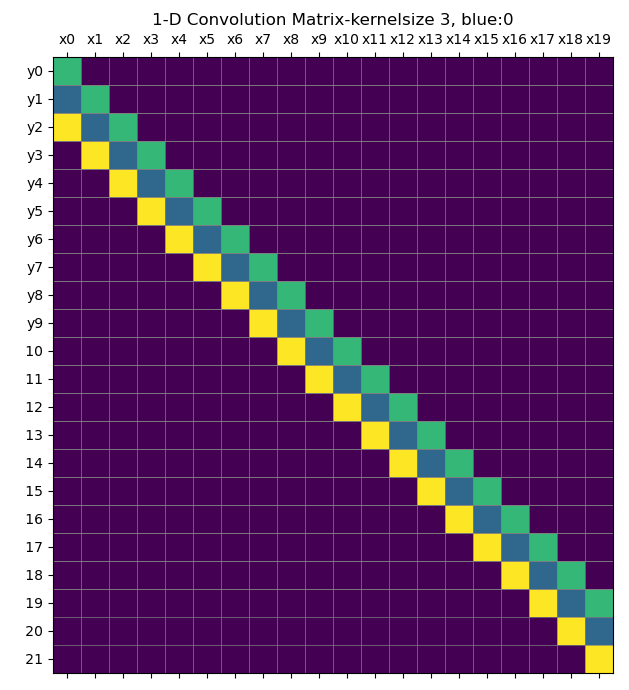

In [4]:
from IPython.display import Image, display
display(Image(filename="1D_convolutional_layer_weight_matrix.png", width=400, height=400)) 

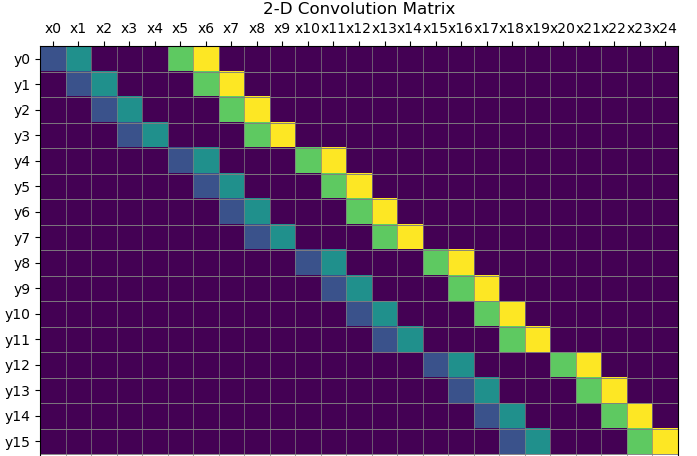

In [5]:
from IPython.display import Image, display
display(Image(filename="2D_convolutiona.png", width=500, height=500)) 

# Tucker Decomposition based Factorization

$$
\mathbf{\mathcal{Y}} = \mathbf{\mathcal{S}} \times_1 \mathbf{D_1} \times_2 \mathbf{D_2} \ldots \times_{J-1} \mathbf{D_{J-1}} \times_J \mathbf{D_J}
$$

The separable multilinear operation can be written in the form of conventional matrix-vector multiplication via:

$$
\mathbf{y} = \left( \mathbf{D_1} \otimes \mathbf{D_2} \otimes \ldots \otimes \mathbf{D_J} \right) \mathbf{s}
$$

where $\otimes$ denotes the Kronecker product, and $\mathbf{y}$ is the vectorized version of the tensor $Y$

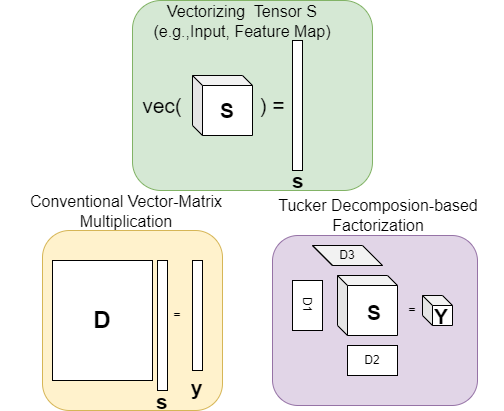

In [6]:
from IPython.display import Image, display
display(Image(filename="tucker.png", width=600, height=600)) 

## GTS Operation

$$
\mathbf{\mathcal{Y}} = \sum_{t=1}^{T} \mathbf{\mathcal{S}} \times_1 \mathbf{D_1^{(t)}} \times_2 \mathbf{D_2^{(t)}} \ldots \times_{J-1} \mathbf{D_{J-1}^{(t)}} \times_J \mathbf{D_J^{(t)}}
$$

where $T$ is the number of different separable CS tensors, and $\mathbf{D_i^{(t)}}$ represents the $i^{th}$ dimension transformation matrix for the $t^{th}$ operation.

### Citation
Yamaç, Mehmet, et al. "Generalized tensor summation compressive sensing network (GTSNET): An easy to learn compressive sensing operation." IEEE Transactions on Image Processing (2023).


# Vector-Matrix Multiplication Reformalization of GTS Operation

We can define a factorized CS matrix, $\mathbf{P}$ as follows:

$$
\mathbf{P} = \sum_{t=1}^{T} \left( \mathbf{D_1^{(t)}} \otimes \mathbf{D_2^{(t)}} \otimes \ldots \otimes \mathbf{D_J^{(t)}} \right)
$$

when we write the vectorized version of measurements, i.e., $\mathbf{y} = \mathbf{P} \mathbf{s}$.


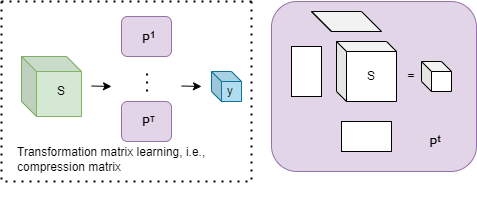

In [7]:
from IPython.display import Image, display
display(Image(filename="GTSmatrix.png", width=600, height=600)) 

# Import MTS operator

MTS is an extension of GTS (Generalized Tensorial Sum Operation), which is suitable for multi-dimensional signal (or latent space signal, e.g., feature maps etc.)

MTS operation: 

$$ 
\mathbf{\mathcal{Y}} = \sum_{sc=1}^{SC} \sum_{t=1}^{T} \mathbf{\mathcal{S}} \times_1 \mathbf{D_1^{(t, sc)}} \times_2 \mathbf{D_2^{(t, sc)}} \ldots \times_{J-1} \mathbf{D_{J-1}^{(t, sc)}} \times_J \mathbf{D_J^{(t, sc)}},
$$
where $sc$ is the corresponding scale (i.e, for window size= [8, 16], sc=1 means GTS that is applied 8x8 block wise divided $\mathbf{S}$ ),  $T$ is the number of different separable CS tensors, and $\mathbf{D_i^{(t)}}$ represents the $i^{th}$ dimension transformation matrix for the $t^{th}$ operation.

MTS operation (in matrix form) :

$$ 
\mathbf{P} = \sum_{sc=1}^{SC}  \sum_{t=1}^{T} \left( \mathbf{D_1^{(t, sc)}} \otimes \mathbf{D_2^{(t, sc)}} \otimes \ldots \otimes \mathbf{D_J^{(t, sc)}} \right). 
$$

on.
rati

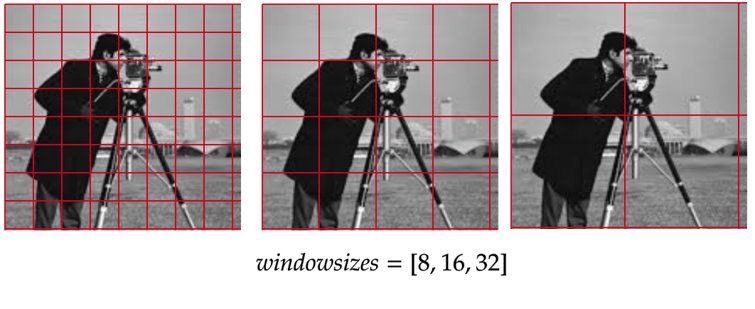

In [8]:
from IPython.display import Image, display
display(Image(filename="Picture1.png", width=600, height=600)) 

# Implementation

## Import MTS operator


# MTS Layer, Computational Complexity, number of parameters

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F


T = 3  # T is given as 3 for this example
window_scales = [8,16, 32, 64]


mts_layer = MultiScale(in_channels=30, out_channels=30, window_scales=[8, 16, 32], out_window_scales=[8,16,32], T=T)

H = W = 256  # Input dimensions

# Calculate GMACs
total_flops = mts_layer.calculate_total_mac(H, W)
print(f"Total GMAC for MTS Layer with H=W=256: {total_flops / 1e9}")

# Create a random tensor with the specified dimensions
input_tensor = torch.rand(1, 30, 256, 256)

output_tensor= mts_layer(input_tensor)
print(output_tensor.shape)

# Calculate # of parameters
print(f"Number of trainable parameters: {count_parameters(mts_layer)}")

Total GMAC for MTS Layer with H=W=256: 1.19144448
torch.Size([1, 30, 256, 256])
Number of trainable parameters: 16164


# Dense Layers vs MTS Factorization

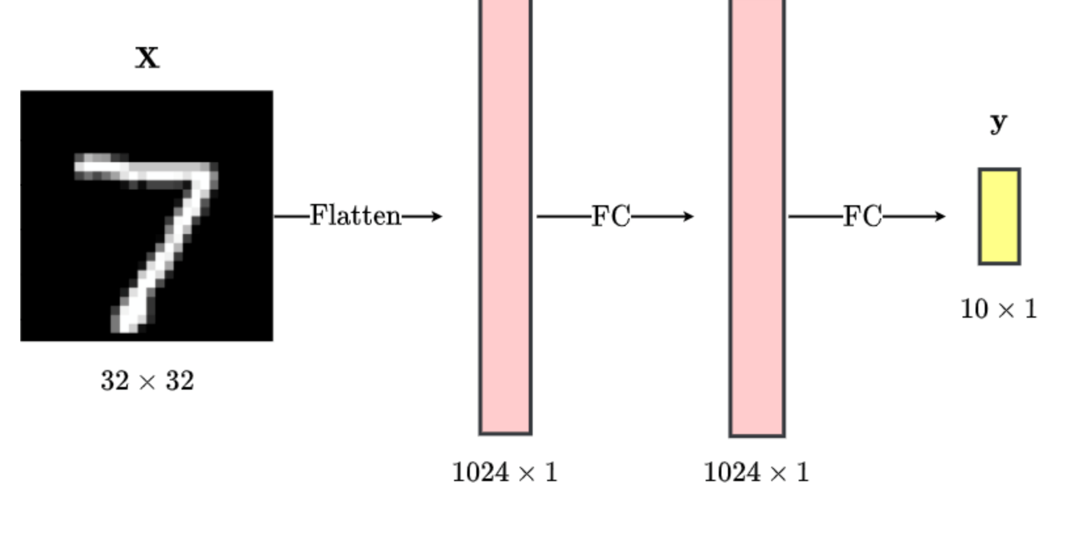

In [26]:
from IPython.display import Image, display
display(Image(filename="Picture2.png", width=600, height=600)) 

# MNIST Dataset Preparation

In [10]:
batch_size = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/', train=False, transform=transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size*500, shuffle=True, num_workers=1)

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST\raw\train-images-idx3-ubyte.gz to ./data/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST\raw\train-labels-idx1-ubyte.gz to ./data/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%

Extracting ./data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/MNIST\raw



# define networks

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class Net(nn.Module):
    def __init__(self, use_tt=None, T=5):
        super(Net, self).__init__()

        self.use_tt = use_tt
        self.T = T

        if use_tt == 'TensorSumNet':
            self.fc1 = MultiScale(in_channels=1, out_channels=1, window_scales=[8, 16], T=T, use_identity_init=False)
            # self.fc2 = nn.Linear(1 * 1024, 10)
            self.fc2 = TensorSumEfficient([1, 32, 32], [1, 2, 5], T=T, init_temperature=1)
            self.network_name = f"{use_tt}-{T}"

        elif use_tt == 'TensorSumNet_Plus':
            self.fc1 = MultiScale(in_channels=1, out_channels=1, window_scales=[8, 16], T=T, use_identity_init=False)
            self.fc2 = nn.Linear(1024, 10)
            self.network_name = f"{use_tt}-{T}"
            # self.fc2 = TensorSum([3, 32, 32], [1, 2, 5], T=T, init_temperature=1)
        else:
            self.fc1 = nn.Linear(1024, 1024)
            self.fc2 = nn.Linear(1024, 10)
            self.network_name = "Linear"

    def get_num_params(self):
        return sum([p.numel() for p in self.parameters() if p.requires_grad])

    def forward(self, x):
        if self.use_tt is None:
            x = torch.nn.Flatten()(x)

        x = F.relu(self.fc1(x))

        if self.use_tt == 'TensorSumNet_Plus':
            x = torch.nn.Flatten()(x)

        x = self.fc2(x)
        if self.use_tt == 'TensorSumNet':
            x = torch.nn.Flatten()(x)

        return F.log_softmax(x, dim=-1)



In [12]:
use_tt_flags =['TensorSumNet', 'TensorSumNet_Plus', None] # ['TensorSumNet','TensorSumNet_Plus', None]  # [None, 'TensorSumNet']
Tparams = [3]
models = []
for flag in use_tt_flags:
    if flag == 'TensorSumNet':
        models += [Net(use_tt=flag, T=t) for t in Tparams]
    elif flag == 'TensorSumNet_Plus':
        models += [Net(use_tt=flag, T=t) for t in Tparams]
    else:
        models.append(Net(use_tt=flag))


In [8]:
print(device)

cuda


In [13]:
import time
import torch.optim as optim
n_epoch = 5 # Number of epochs

lr = 1e-3  # Starting learning rate
gamma = 0.5  # Learning rate decay factor
#step_size = 20  # Number of epochs before learning rate decay
milestones = [50, 70, 90]  # Epochs at which to reduce the learning rat3
model_psnr = []
model_parameters = []

models_acc = []
for i, model in enumerate(models):
    model = model.to(device)
    print('Training network {}...'.format(i))
    start = time.process_time()
    
    
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    #scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    criterion=nn.CrossEntropyLoss()

    def train(n_epoch):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            #print(data.shape)

            # Important: do not forget to reset the gradients
            optimizer.zero_grad()

            output = model(data)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()

    def test():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = criterion(output,target)
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        test_loss /= len(test_loader.dataset)
        
        return 100. * correct / len(test_loader.dataset)

    for epoch in range(1, n_epoch):
        train(epoch)
        #scheduler.step()  # Update learning rate
        if epoch in milestones:
            current_lr = scheduler.get_lr()[0]
            print(f'Learning rate reduced to {current_lr} at epoch {epoch}')
        acc = test()
        if epoch % 1 == 0:
            acc = test()
            print('Epoch {}:\tTest set accuracy: {}'.format(epoch, acc))
           
        
    print('Test set acc: {}%\tTime taken: {}'.format(acc, time.process_time() - start))
    models_acc += [acc]
 

Training network 0...
Epoch 1:	Test set accuracy: 93.83999633789062
Epoch 2:	Test set accuracy: 94.05000305175781
Epoch 3:	Test set accuracy: 95.33000183105469
Epoch 4:	Test set accuracy: 94.77999877929688
Test set acc: 94.77999877929688%	Time taken: 53.21875
Training network 1...
Epoch 1:	Test set accuracy: 95.19999694824219
Epoch 2:	Test set accuracy: 95.55999755859375
Epoch 3:	Test set accuracy: 96.69999694824219
Epoch 4:	Test set accuracy: 96.54000091552734
Test set acc: 96.54000091552734%	Time taken: 101.1875
Training network 2...
Epoch 1:	Test set accuracy: 93.13999938964844
Epoch 2:	Test set accuracy: 95.05000305175781
Epoch 3:	Test set accuracy: 95.9800033569336
Epoch 4:	Test set accuracy: 96.5199966430664
Test set acc: 96.5199966430664%	Time taken: 65.75


In [9]:
models[0].get_num_params()

2601

In [10]:
models[1].get_num_params()

12176

In [11]:
models[2].get_num_params()

1059850

# Vaninall CNN vs Vanilla MTS

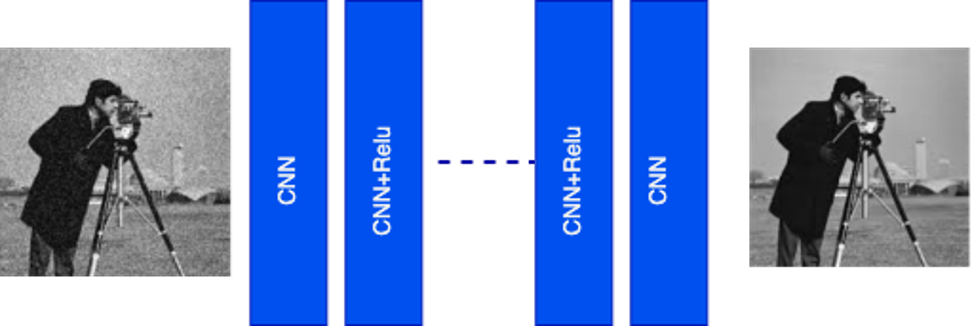

In [12]:
from IPython.display import Image, display
display(Image(filename="cnn.png", width=600, height=600)) 

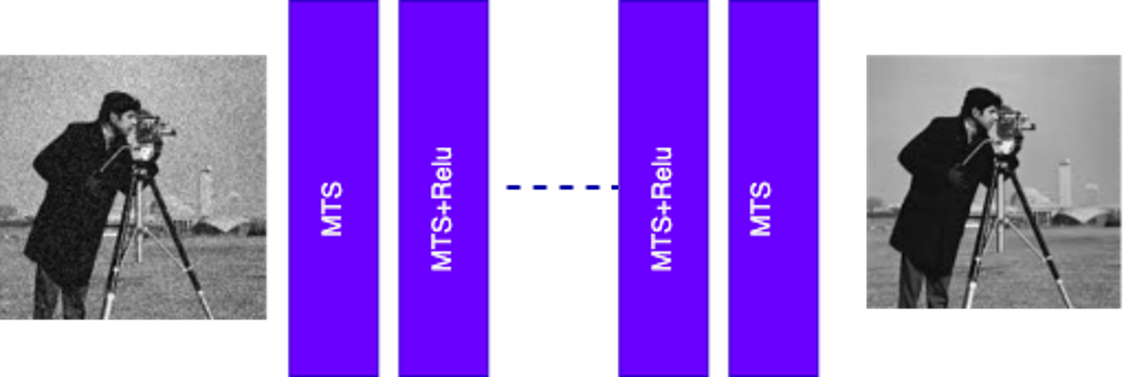

In [13]:
from IPython.display import Image, display
display(Image(filename="MTSTiny.png", width=600, height=600)) 

In [4]:
from torch import nn
class TinyCNNNet(nn.Module):
    def __init__(self, L, N,residual=False):
        super(TinyCNNNet, self).__init__()
        
        self.residual = residual
        print('residual:')
        print(self.residual)
        # First layer
        self.conv1 = nn.Conv2d(3, N, 3, padding=1)
        self.relu1 = nn.ReLU()
        
        # Middle layers
        self.layers = nn.ModuleList()
        for i in range(L-2):
            self.layers.append(nn.Conv2d(N, N, 3, padding=1))
            self.layers.append(nn.ReLU())
        
        # Last layer
        self.conv_last = nn.Conv2d(N, 3, 3, padding=1)
        
    def forward(self, x):
        # First layer
        out = self.conv1(x)
        out = self.relu1(out)
        
        # Middle layers
        for layer in self.layers:
            out = layer(out)
        
        # Last layer
        out = self.conv_last(out)
        if self.residual:
            out=out+x
        
        return out

In [14]:
class TinyTensorNet(nn.Module):
    def __init__(self, L, N, window_scales=[8,16,32,64],T=3,residual=True):
        super(TinyTensorNet, self).__init__()
        
        # Define maximum patch size
        self.p = window_scales[-1]
        self.residual = residual
        print('residual:')
        print(self.residual)
        # First layer
        self.ten1=MultiScale(in_channels=3, 
                             out_channels=N,
                             T=T,
                             window_scales=window_scales,
                             out_window_scales=window_scales)
        
        self.relu1 = nn.ReLU()
        
        # Middle layers
        self.layers = nn.ModuleList()
        for i in range(L-2):
            self.layers.append(MultiScale(
            in_channels=N,
            out_channels=N,
            T=T,
            window_scales=window_scales,
            out_window_scales=window_scales))
            self.layers.append(nn.ReLU())
        
        # Last layer, select either convolution or MTS layer, one conv layer can further increase
        #the receptive field
        self.ten_last = MultiScale(
            in_channels=N,
            out_channels=3,
            T=T,
            window_scales=window_scales,
            out_window_scales=window_scales)
        
    def forward(self, x):
        # Calculate the padding amounts along height and width dimensions
        sx, sy = x.shape[2:]
        px = (self.p - (sx % self.p)) % self.p
        py = (self.p - (sy % self.p)) % self.p
        # Apply padding using PyTorch's nn.functional.pad() function
        x = torch.nn.functional.pad(x, (0, py, 0, px), mode='reflect')
        # First layer
        out = self.ten1(x)
        out = self.relu1(out)
        
        # Middle layers
        for layer in self.layers:
            out = layer(out)
        
        # Last layer
        out = self.ten_last(out)
        if self.residual:
            out=out+x
        out = out[:,:,:sx,:sy]
        return out

    
    def calculate_total_mac(self, H, W):
        total_macs = 0

        total_macs += self.ten1.calculate_total_mac(H,W)

        # Calculate MACs for each MTSL layer
        for mts in self.layers:
            if isinstance(mts, nn.ReLU):
                continue
            #print(mts)
            total_macs += mts.calculate_total_mac(H, W)
            
        total_macs += self.ten_last.calculate_total_mac(H,W)
        
        # Calculate MACs for the conv2d layer
        #conv2d_macs = calculate_conv_Mac(self.out_channels, self.out_channels, H, W, self.kernel_size, 1)

        # Add conv2d MACs to the total
        #total_macs += conv2d_macs

        return total_macs


In [15]:
model1=TinyTensorNet(N=48,L=4)

residual:
True


In [16]:
# Create a random tensor with the specified dimensions
input_tensor = torch.rand(1, 3, 256, 256)

output_tensor= model1(input_tensor)
print(output_tensor.shape)

torch.Size([1, 3, 256, 256])


In [17]:
# Calculate GMACs
total_flops = model1.calculate_total_mac(256,256)
print(f"Total GMAC for MTSNetTiny with H=W=256: {total_flops / 1e9}")

Total GMAC for MTSNetTiny with H=W=256: 10.786701312
